### Fix matplotlib [bug](https://discussions.udacity.com/t/attributeerror-numpy-ndarray-object-has-no-attribute-mask-after-extracting-celeba/684064/13)

In [1]:
# !sudo pip install -U matplotlib==2.2.2

In [2]:
# check for version of matplotlib without ndarray has no attribute 'mask', should be 2.2.2
!pip freeze | grep matplotlib

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
matplotlib==2.2.2


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

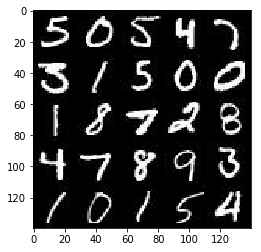

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L').convert("RGB"), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

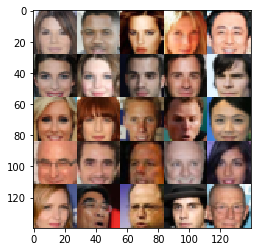

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    drop_rate = 0.10
    
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input layer is 28 x 28 x number of channels

        # conv layer 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # output is 14 x 14 x 64
        
        # conv layer 2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True) # batch norm
        bn2 = tf.layers.dropout(bn2, rate=drop_rate)
        relu2 = tf.maximum(alpha * bn2, bn2) # leaky relu
        # output is 7 x 7 x 128
        
        # conv layer 3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True) # batch norm
        bn3 = tf.layers.dropout(bn3, rate=drop_rate)
        relu3 = tf.maximum(alpha * bn3, bn3) # leaky relu
        # output is 4 x 4 x 256 (with padding same)

        # dense layer
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256)) # flatten to n x 4096
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train # don't reuse the parameters when training
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train) # batch norm
        x1 = tf.maximum(alpha * x1, x1) # leaky relu
        # output is 4 x 4 x 512
        
        # First conv layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=initializer)
        x2 = tf.layers.batch_normalization(x2, training=is_train) # batch norm
        x2 = tf.maximum(alpha * x2, x2) # leaky relu
        # output is 7 x 7 x 256
        
        # Second conv layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        x3 = tf.layers.batch_normalization(x3, training=is_train) # batch norm
        x3 = tf.maximum(alpha * x3, x3) # leaky relu
        # output is 14 x 14 x 128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=initializer)
        # output is 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # get fake data from generator
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    # get discriminator predictions for real and fake images
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha) # input is from generator

    # discriminator loss for real images (labels are all ones)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    # discriminator loss for fake data (labels are all zeros)
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    # total generator loss
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias variables
    t_vars = tf.trainable_variables()
    
    # Separate discriminator and generator variables using scope
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_w, img_h, img_c = data_shape
    input_real, input_z, learn_rate = model_inputs(img_w, img_h, img_c, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, img_c, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                # scale batch images by 2 from -0.5, 0.5 to -1.0, 1.0
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                # get loss info every several epochs
                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # get sample images
                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, img_c, data_image_mode)
                    
        # show final image after last epoch has run
        print("\nImages from final model:")
        show_generator_output(sess, 25, input_z, img_c, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 1.5944
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.9559
Epoch 1/2... Discriminator Loss: 1.6215... Generator Loss: 1.3314
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 1.3135
Epoch 1/2... Discriminator Loss: 1.5990... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 1.6216... Generator Loss: 0.3773


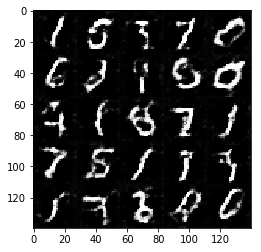

Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.4226
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.3945


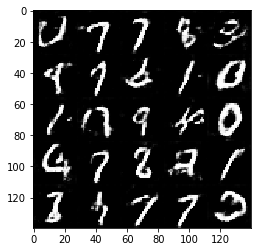

Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 1.8234
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.3847
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 1.2597
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.7590... Generator Loss: 0.3373


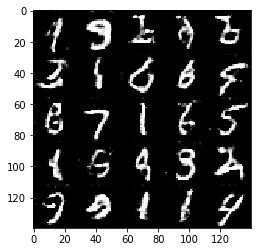

Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 2.1970
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.2455
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.8956
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.5893
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 1.9148
Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.1810
Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.0139


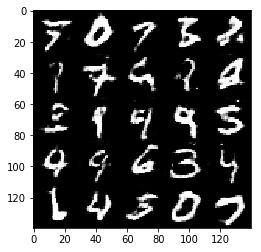

Epoch 2/2... Discriminator Loss: 0.7216... Generator Loss: 2.3056
Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 3.8081
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.2593
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.2215
Epoch 2/2... Discriminator Loss: 2.1907... Generator Loss: 0.2467
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.8225
Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 3.1357
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.8363


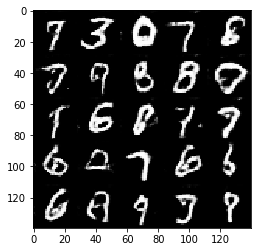

Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.5153
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.5843
Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.2971
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 2.3136
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.0772
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.0981
Epoch 2/2... Discriminator Loss: 1.8160... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.9250
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.5944


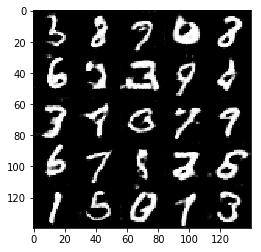

Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 2.0431
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 2.3802
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 2.1436
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 2.0649
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 2.3535
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 2.1797


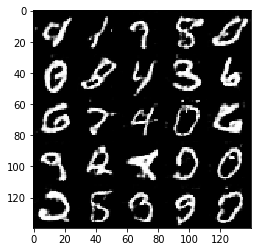

Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 1.5986
Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 1.8367
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 1.4416
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 2.2683

Images from final model:


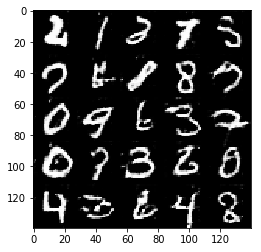

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2
alpha = 0.2


tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7767... Generator Loss: 10.9458
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 3.2184
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 3.3283
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.9821
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 2.0569
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.7804


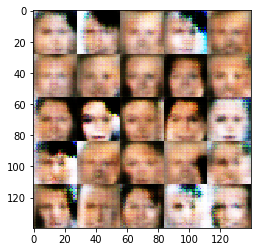

Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.4800
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.7629
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 2.6671
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 3.0446
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 2.0524


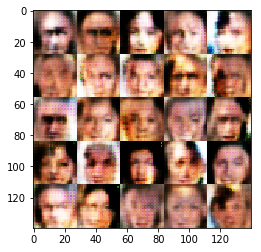

Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 3.2531
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 1.8357
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 2.1436
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 1.7824
Epoch 1/1... Discriminator Loss: 1.8201... Generator Loss: 2.8722
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 3.0271
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 2.4102
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.4725
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 3.1260


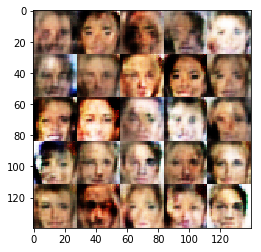

Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 2.3510
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 2.6479
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 2.1431
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 3.0577
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 2.5547
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 2.6467
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 2.3072
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 2.2182


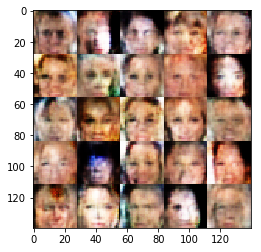

Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.1104
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 3.0372
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.7692
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 3.2875
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.4566
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 2.3647
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 3.1497
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 3.7343
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.8371
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 3.7070


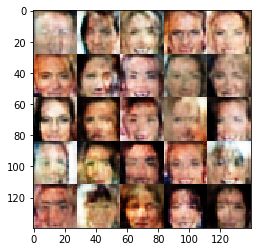

Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 4.5502
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 3.0789
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 2.9143
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 4.3241
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 2.9495
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 3.6255


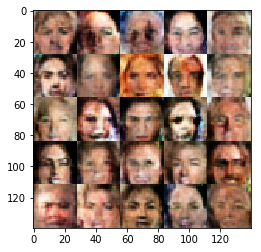

Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 4.8508
Epoch 1/1... Discriminator Loss: 1.9644... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.7639
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.0261
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.8255
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 2.1880
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 2.8686
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 5.2350
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.5238


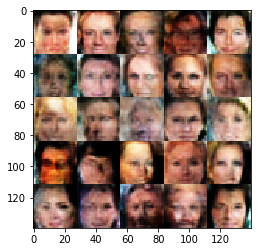

Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 3.0255
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 4.2565
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 2.8361
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 3.1622
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.1666
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.6090
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.9660
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.7459
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 3.8705
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 4.6225


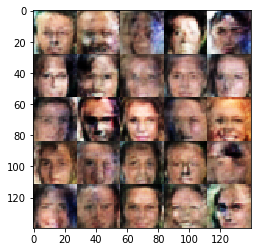

Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.3492
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.9125
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.8008
Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 2.1536
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 2.6044
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.6176
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 2.1535
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 3.8379
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 3.0936
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 2.0116


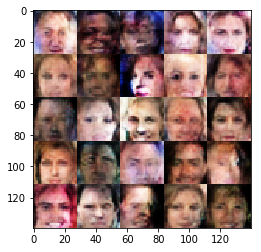

Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 3.7021
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.0938
Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 4.1880
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 4.3934
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.9158
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.5740
Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 2.9342
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 3.7365
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.1010
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5347


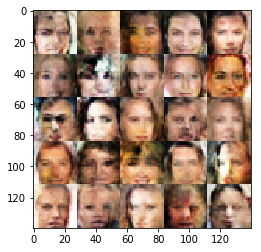

Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.9243
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 3.0351... Generator Loss: 7.2176
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.3852
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 4.2343
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 5.6620
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 4.4528
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 2.8365
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 2.3806


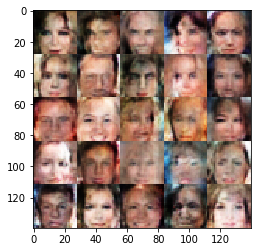

Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 2.7750
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 2.8639
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.3090
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 5.3318
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 4.4902
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.3992
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 4.0440
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 4.4754
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 5.4464


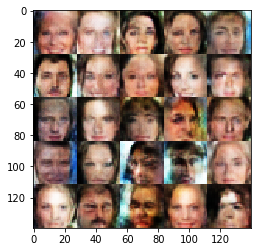

Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 3.6087
Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 4.5178
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 2.0170
Epoch 1/1... Discriminator Loss: 2.5445... Generator Loss: 6.4087
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.1473

Images from final model:


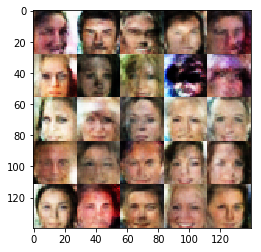

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.